# STAN47: Project

## Title: Sports Image Classification Using CNNs

Authors: Felix Hult, Evagelos Ifantidis and Dennis Markovic

Data: [Sports Image Classification](https://www.kaggle.com/datasets/sidharkal/sports-image-classification/data)

In [1]:
# Import libraries
import os
import shutil
import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.metrics import confusion_matrix

import tensorflow as tf



### Restructuring Directory

Make sure the file "dataset" is under the current working directory.

In [2]:
# Define paths
cwd = os.getcwd()
dataset_path = os.path.join(os.getcwd(), "dataset")
train_csv = os.path.join(dataset_path, "train.csv")
test_csv = os.path.join(dataset_path, "test.csv")
sample_sub = os.path.join(dataset_path, "sample_submission.csv")
train_images_path = os.path.join(dataset_path, "train")
test_images_path = os.path.join(dataset_path, "test")

# New paths
labels_csv = os.path.join(dataset_path, "labels.csv")
images_path = os.path.join(dataset_path, "images")

# Delete test.csv, sample.submission.csv and test/ folder
if os.path.exists(test_csv):
    os.remove(test_csv)

if os.path.exists(sample_sub):
    os.remove(sample_sub)

if os.path.exists(test_images_path):
    shutil.rmtree(test_images_path)  # Deletes the entire test folder and its contents

# Rename train.csv to labels.csv
if os.path.exists(train_csv):
    os.rename(train_csv, labels_csv)

# Rename train folder to images
if os.path.exists(train_images_path):
    os.rename(train_images_path, images_path)

In [3]:
# Organize images into class-labeled folders inside "images/"
df = pd.read_csv(labels_csv)

for _, row in df.iterrows():
    image_id = row[0]  # First column: image filename
    label = row[1]  # Second column: class label

    class_folder = os.path.join(images_path, label)
    os.makedirs(class_folder, exist_ok=True)  # Create class folder if it doesn't exist

    src = os.path.join(images_path, image_id)
    dst = os.path.join(class_folder, image_id)

    if os.path.exists(src):
        shutil.move(src, dst)

print("Dataset restructuring complete!")

/var/folders/nf/fc1yz8fx5w38vl6f32tc2s2r0000gn/T/ipykernel_59482/2624751485.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  image_id = row[0]  # First column: image filename
/var/folders/nf/fc1yz8fx5w38vl6f32tc2s2r0000gn/T/ipykernel_59482/2624751485.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  label = row[1]  # Second column: class label


Dataset restructuring complete!


### Base Model

#### Load data

In [4]:
batch_size = 64
img_height = 180
img_width = 180
data_dir = os.path.join(dataset_path, "images")

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size,
  color_mode = "rgb"
  )

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size,
  color_mode = "rgb"
  )

Found 8227 files belonging to 7 classes.
Using 6582 files for training.
Found 8227 files belonging to 7 classes.
Using 1645 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']


2025-03-17 17:09:03.953681: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


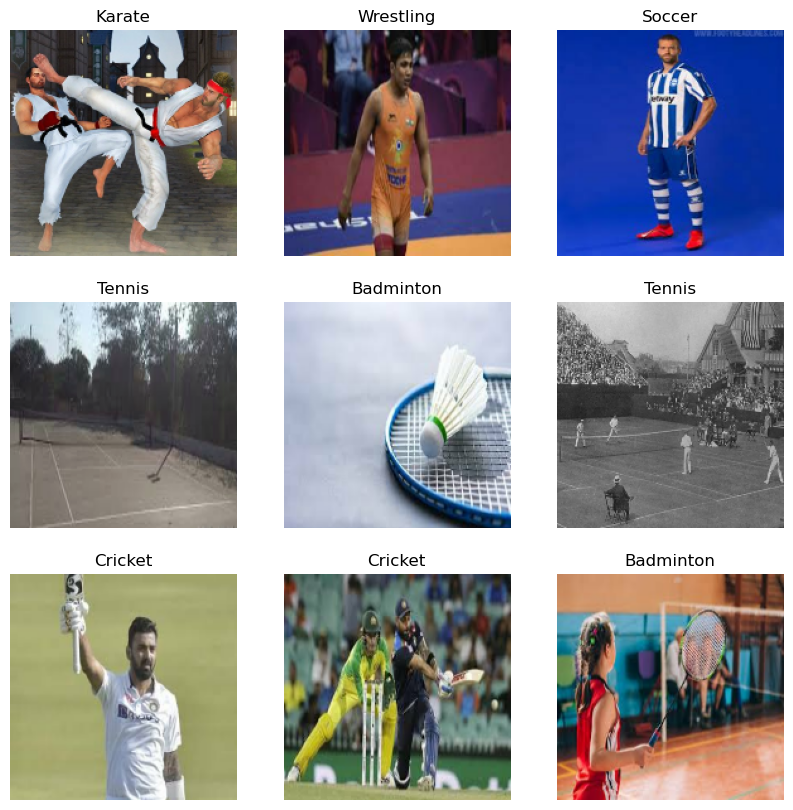

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


#### Data Preprocessing

In [8]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [9]:
# Standardize the data
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [12]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds= train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Train model

In [13]:
num_classes = 7

model_base = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180, 180, 3)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [14]:
model_base.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [15]:
history_base = model_base.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
    )

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 390ms/step - accuracy: 0.2811 - loss: 1.7724 - val_accuracy: 0.5082 - val_loss: 1.2923
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.5732 - loss: 1.1899 - val_accuracy: 0.6049 - val_loss: 1.0637
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 353ms/step - accuracy: 0.6940 - loss: 0.8992 - val_accuracy: 0.6322 - val_loss: 1.0355
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 351ms/step - accuracy: 0.7589 - loss: 0.7097 - val_accuracy: 0.6480 - val_loss: 0.9823
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.8016 - loss: 0.5772 - val_accuracy: 0.7234 - val_loss: 0.8209
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 368ms/step - accuracy: 0.8412 - loss: 0.4614 - val_accuracy: 0.7422 - val_loss: 0.8495
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 37s 355ms/step - accuracy: 0.8827 - loss: 0.3567 - val_accuracy: 0.7416 - val_loss: 0.8392
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 337ms/step - accuracy: 0.9188 - loss: 0

### Optimizers

Note: Instead of explicitly writing separate code for each optimizer, the model was manually adjusted and re-run iteratively to test different optimizers (Adam, SGD, and RMSprop)

In [16]:
# num_classes = 7

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(180, 180, 3)),
#     tf.keras.layers.Rescaling(1./255),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

# # %%
# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#   metrics=['accuracy'])

# # Generate a filename based on model architecture
# timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# architecture_summary = f"CNN_32-64-128_Dense-128"

# log_dir = "training_logs"
# os.makedirs(log_dir, exist_ok=True)
# log_filename = os.path.join(log_dir, f"training_{architecture_summary}_{timestamp}.log")

# # Create a subdirectory for saving confusion matrices
# conf_matrix_dir = os.path.join(log_dir, f"confusion_matrices_{timestamp}")
# os.makedirs(conf_matrix_dir, exist_ok=True)

# # Logging function
# def log_to_file(message):
#     with open(log_filename, "a") as f:
#         f.write(message + "\n")
#     print(message)  # Also print to console

# # Function to log epoch results and save confusion matrices
# def log_epoch_results(epoch, logs):
#     log_to_file(f"Epoch {epoch+1}: Loss={logs['loss']:.4f}, Accuracy={logs['accuracy']:.4f}, "
#                 f"Val_Loss={logs['val_loss']:.4f}, Val_Accuracy={logs['val_accuracy']:.4f}")
    
#     # Generate predictions for validation set
#     y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)  # Assuming val_ds is a TensorFlow dataset
#     y_pred = np.argmax(model.predict(val_ds), axis=-1)

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)

#     # Plot and save confusion matrix
#     plt.figure(figsize=(6, 5))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.arange(len(cm)), yticklabels=np.arange(len(cm)))
#     plt.xlabel("Predicted Label")
#     plt.ylabel("True Label")
#     plt.title(f"Confusion Matrix - Epoch {epoch+1}")

#     cm_filename = os.path.join(conf_matrix_dir, f"confusion_matrix_epoch_{epoch+1}.png")
#     plt.savefig(cm_filename)
#     plt.close()
    
# # Save model architecture to log
# with open(log_filename, "w") as f:
#     f.write("Model Architecture:\n")
#     model.summary(print_fn=lambda x: f.write(x + "\n"))

# # Training loop with interruption handling
# try:
#     log_to_file("\nTraining started...\n")
    
#     history = model.fit(
#         train_ds,
#         validation_data=val_ds,
#         epochs=20,
#         callbacks=[tf.keras.callbacks.LambdaCallback(
#             on_epoch_end=lambda epoch, logs: log_epoch_results(epoch, logs)
#         )]
#     )
#     log_to_file("\nTraining completed successfully.")

# except KeyboardInterrupt:
#     log_to_file("\nTraining interrupted by user. Partial results saved.")



### Regularization

In [17]:
# Add dropout
num_classes = 7

model_dropout = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180, 180, 3)),
  tf.keras.layers.Rescaling(1./255),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Conv2D(32, 3, activation='relu'),

  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128,activation='relu'),
  tf.keras.layers.Dropout(0.5),

  tf.keras.layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])


In [18]:
model_dropout.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
history_dropout=model_dropout.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 366ms/step - accuracy: 0.2301 - loss: 1.8600 - val_accuracy: 0.3021 - val_loss: 1.7539
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 333ms/step - accuracy: 0.3411 - loss: 1.6453 - val_accuracy: 0.4523 - val_loss: 1.4759
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 34s 326ms/step - accuracy: 0.4165 - loss: 1.5064 - val_accuracy: 0.5064 - val_loss: 1.3713
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 323ms/step - accuracy: 0.4441 - loss: 1.4173 - val_accuracy: 0.5897 - val_loss: 1.2340
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 341ms/step - accuracy: 0.4851 - loss: 1.3276 - val_accuracy: 0.5769 - val_loss: 1.2247
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.5139 - loss: 1.2525 - val_accuracy: 0.5842 - val_loss: 1.1655
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 35s 342ms/step - accuracy: 0.5189 - loss: 1.2150 - val_accuracy: 0.6249 - val_loss: 1.1040
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 353ms/step - accuracy: 0.5436 - loss: 1

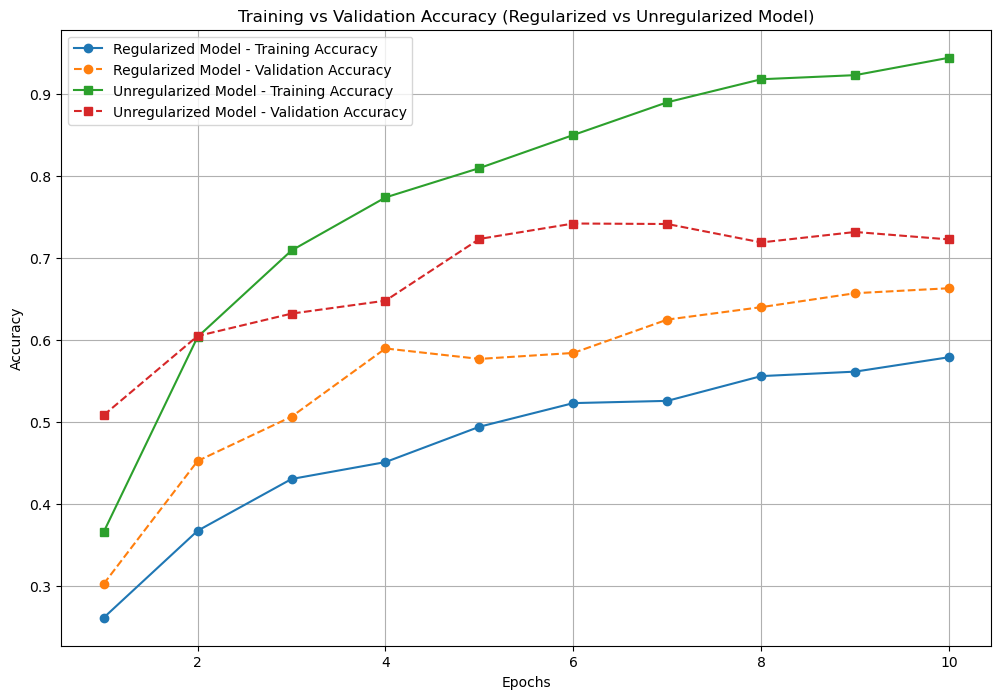

In [21]:
import matplotlib.pyplot as plt

# Extract accuracy values from both models
train_acc_base = history_base.history['accuracy']
val_acc_base = history_base.history['val_accuracy']

train_acc_dropout = history_dropout.history['accuracy']
val_acc_dropout = history_dropout.history['val_accuracy']

epochs_range = range(1, len(train_acc_dropout) + 1)

# Plot accuracy for both models
plt.figure(figsize=(12, 8))
plt.plot(epochs_range, train_acc_dropout, label='Regularized Model - Training Accuracy', marker='o', linestyle='-')
plt.plot(epochs_range, val_acc_dropout, label='Regularized Model - Validation Accuracy', marker='o', linestyle='--')

plt.plot(epochs_range, train_acc_base, label='Unregularized Model - Training Accuracy', marker='s', linestyle='-')
plt.plot(epochs_range, val_acc_base, label='Unregularized Model - Validation Accuracy', marker='s', linestyle='--')

# Labels and title
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy (Regularized vs Unregularized Model)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

### Grayscale vs. Color

#### Load data

In [22]:
batch_size = 64
img_height = 180
img_width = 180
data_dir = os.path.join(dataset_path, "images")

train_ds_gray = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size,
  color_mode = "grayscale"
  )

val_ds_gray = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size = batch_size,
  color_mode = "grayscale"
  )

Found 8227 files belonging to 7 classes.
Using 6582 files for training.
Found 8227 files belonging to 7 classes.
Using 1645 files for validation.


In [23]:
class_names = train_ds_gray.class_names
print(class_names)

['Badminton', 'Cricket', 'Karate', 'Soccer', 'Swimming', 'Tennis', 'Wrestling']


2025-03-17 17:31:10.984081: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


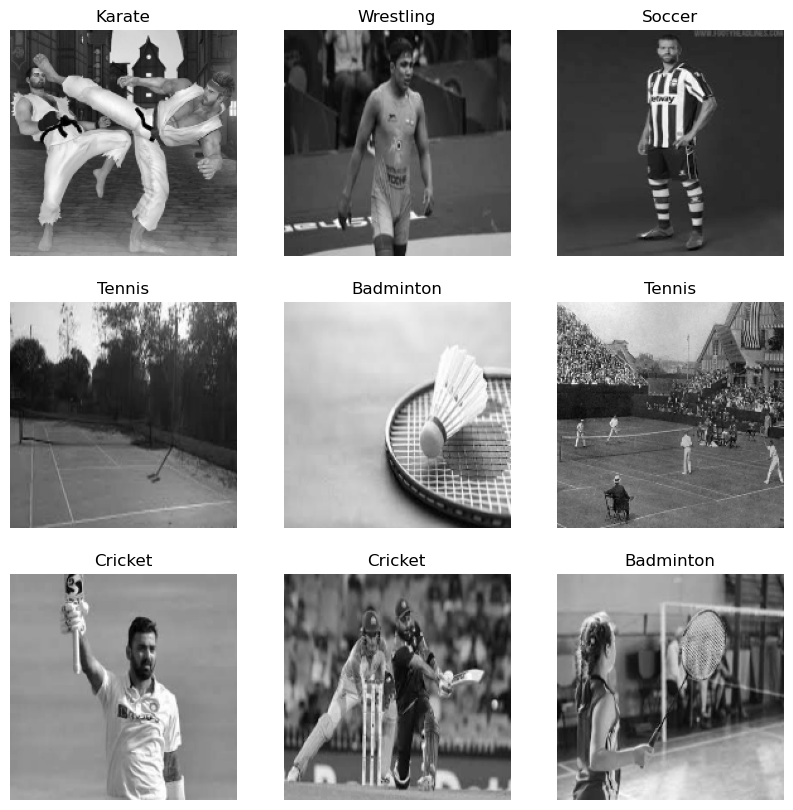

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds_gray.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds_gray:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 1)
(64,)


#### Data Preprocessing

In [26]:
# Define normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [27]:
# Standardize the data
normalized_ds = train_ds_gray.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))


0.08398701 1.0


In [28]:
# Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

train_ds_gray= train_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)
val_ds_gray = val_ds_gray.cache().prefetch(buffer_size=AUTOTUNE)

#### Train model

In [29]:
num_classes = 7

model_gray = tf.keras.Sequential([
  tf.keras.layers.Input(shape=(180, 180, 1)),
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [30]:
model_gray.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [31]:
history_gray = model_gray.fit(
    train_ds_gray,
    validation_data=val_ds_gray,
    epochs=10
    )

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 36s 340ms/step - accuracy: 0.2618 - loss: 1.8182 - val_accuracy: 0.3903 - val_loss: 1.6148
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 314ms/step - accuracy: 0.4491 - loss: 1.4809 - val_accuracy: 0.4486 - val_loss: 1.4789
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 33s 320ms/step - accuracy: 0.5498 - loss: 1.2732 - val_accuracy: 0.5131 - val_loss: 1.3229
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 307ms/step - accuracy: 0.6490 - loss: 1.0111 - val_accuracy: 0.5556 - val_loss: 1.3280
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 310ms/step - accuracy: 0.7270 - loss: 0.7788 - val_accuracy: 0.5787 - val_loss: 1.3685
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 32s 313ms/step - accuracy: 0.8068 - loss: 0.5665 - val_accuracy: 0.5653 - val_loss: 1.5156
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.8616 - loss: 0.4141 - val_accuracy: 0.5927 - val_loss: 1.6905
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 31s 305ms/step - accuracy: 0.8693 - loss: 0

### Plot results

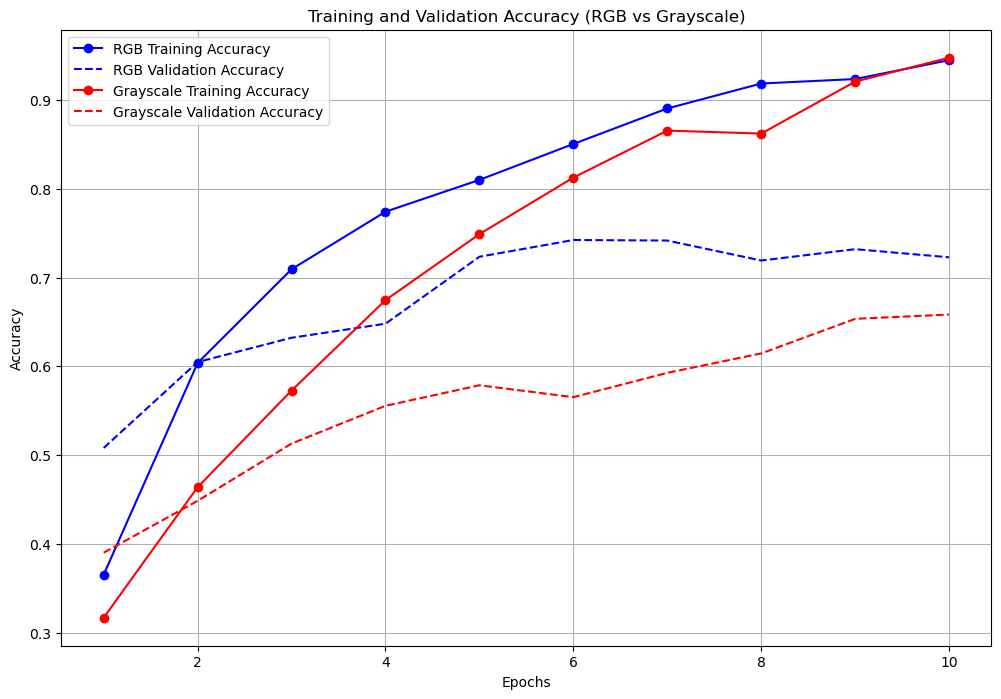

In [32]:
import matplotlib.pyplot as plt

def plot_training_history(history_base, history_gray):
    epochs = range(1, len(history_base.history['accuracy']) + 1)
    
    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history_base.history['accuracy'], 'bo-', label='RGB Training Accuracy')
    plt.plot(epochs, history_base.history['val_accuracy'], 'b--', label='RGB Validation Accuracy')
    plt.plot(epochs, history_gray.history['accuracy'], 'ro-', label='Grayscale Training Accuracy')
    plt.plot(epochs, history_gray.history['val_accuracy'], 'r--', label='Grayscale Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (RGB vs Grayscale)')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the training and validation accuracy
plot_training_history(history_base, history_gray)

### ResNet

In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# Load the ResNet50 model with pretrained ImageNet weights
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(180, 180, 3))

# Freeze the base model
base_model.trainable = False

# Build a simple model on top
model_resnet = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduces dimensions while preserving information
    layers.Dense(128, activation='relu'),  # Small dense layer for learning task-specific features
    layers.Dense(7, activation='softmax')  # Output layer for 7 classes
])

# Compile the model
model_resnet.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the model
history_resnet = model_resnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.5868 - loss: 1.3086 - val_accuracy: 0.8255 - val_loss: 0.4882
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.8607 - loss: 0.3984 - val_accuracy: 0.8571 - val_loss: 0.3893
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 130s 1s/step - accuracy: 0.9016 - loss: 0.2931 - val_accuracy: 0.8881 - val_loss: 0.3408
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.9295 - loss: 0.2147 - val_accuracy: 0.8851 - val_loss: 0.3364
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9502 - loss: 0.1647 - val_accuracy: 0.8815 - val_loss: 0.3376
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9688 - loss: 0.1238 - val_accuracy: 0.8663 - val_loss: 0.3701
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.9678 - loss: 0.1130 - val_accuracy: 0.8565 - val_loss: 0.4163
Epoch 8/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 129s 1s/step - accuracy: 0.9608 - loss: 0.1187 - val_accu

### Plot results

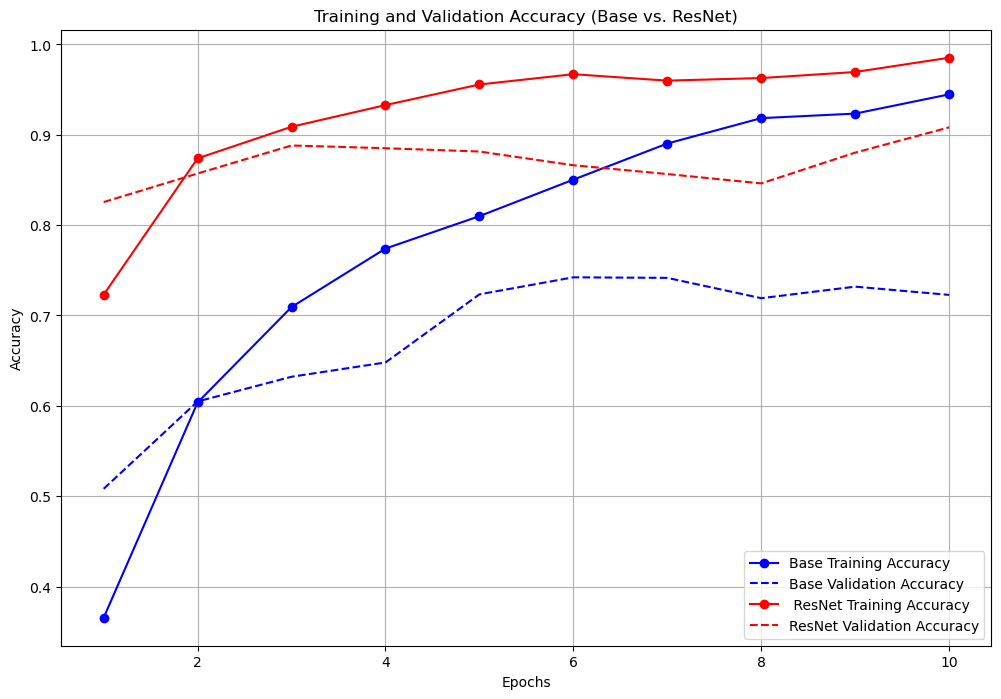

In [34]:
import matplotlib.pyplot as plt

def plot_training_history(history_base, history_resnet):
    epochs = range(1, len(history_base.history['accuracy']) + 1)
    
    # Plot Training and Validation Accuracy
    plt.figure(figsize=(12, 8))
    plt.plot(epochs, history_base.history['accuracy'], 'bo-', label='Base Training Accuracy')
    plt.plot(epochs, history_base.history['val_accuracy'], 'b--', label='Base Validation Accuracy')
    plt.plot(epochs, history_resnet.history['accuracy'], 'ro-', label=' ResNet Training Accuracy')
    plt.plot(epochs, history_resnet.history['val_accuracy'], 'r--', label='ResNet Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy (Base vs. ResNet)')
    plt.legend()
    plt.grid()
    plt.show()

# Plot the training and validation accuracy
plot_training_history(history_base, history_resnet)